## DS6003 Homework01_Spark
## Jingyi Luo (jl6zh)

In [1]:
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

### Setting up spark environment

In [2]:
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)

### Read in data from S3

In [20]:
# read in data from S3 as a pandas dataframe
role = get_execution_role()
bucket = 'odl-spark19spds6003-001'
data_key = 'jl6zh/Admission_Predict.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
pddf = pd.read_csv(data_location)

# replace space in column names with underscore
pddf.columns = [x.strip().replace(' ', '_') for x in pddf.columns]

# convert pandas dataframe to spark dataframe
df = sqlc.createDataFrame(pddf)
df

DataFrame[Serial_No.: bigint, GRE_Score: bigint, TOEFL_Score: bigint, University_Rating: bigint, SOP: double, LOR: double, CGPA: double, Research: bigint, Chance_of_Admit: double]

In [21]:
df.take(3)

[Row(Serial_No.=1, GRE_Score=337, TOEFL_Score=118, University_Rating=4, SOP=4.5, LOR=4.5, CGPA=9.65, Research=1, Chance_of_Admit=0.92),
 Row(Serial_No.=2, GRE_Score=324, TOEFL_Score=107, University_Rating=4, SOP=4.0, LOR=4.5, CGPA=8.87, Research=1, Chance_of_Admit=0.76),
 Row(Serial_No.=3, GRE_Score=316, TOEFL_Score=104, University_Rating=3, SOP=3.0, LOR=3.5, CGPA=8.0, Research=1, Chance_of_Admit=0.72)]

### Convert to parquet

In [20]:
#df = df.withColumnRenamed("Serial No.", "Serial_No.")
#df.take(1)

[Row(Serial_No.=1, GRE Score=337, TOEFL Score=118, University Rating=4, SOP=4.5, LOR =4.5, CGPA=9.65, Research=1, Chance of Admit =0.92)]

In [24]:
parquetPath = '/home/ec2-user/SageMaker/jl6zh/homework/data_parq'
df.write.parquet(parquetPath)

### Write parquet to S3

In [25]:
s3 = boto3.resource('s3')
files = [f for f in listdir(parquetPath) if isfile(join(parquetPath, f))]
for f in files:
    s3.Bucket(bucket).upload_file(parquetPath+'/'+f, 'jl6zh/parq_'+f)

### Read parquet from S3
### Make Spark dataframe from parquet

In [44]:
# write to spark dataframe from parquet locally
df = sqlc.read.parquet(parquetPath)
df
#parquetFile = sqlc.read.parquet("s3://odl-spark19spds6003-001/jl6zh/parq_/*")

DataFrame[Serial_No.: bigint, GRE_Score: bigint, TOEFL_Score: bigint, University_Rating: bigint, SOP: double, LOR: double, CGPA: double, Research: bigint, Chance_of_Admit: double]

In [45]:
df.printSchema()

root
 |-- Serial_No.: long (nullable = true)
 |-- GRE_Score: long (nullable = true)
 |-- TOEFL_Score: long (nullable = true)
 |-- University_Rating: long (nullable = true)
 |-- SOP: double (nullable = true)
 |-- LOR: double (nullable = true)
 |-- CGPA: double (nullable = true)
 |-- Research: long (nullable = true)
 |-- Chance_of_Admit: double (nullable = true)



### ML pipeline

#### select a demo data

In [46]:
display(df)

DataFrame[Serial_No.: bigint, GRE_Score: bigint, TOEFL_Score: bigint, University_Rating: bigint, SOP: double, LOR: double, CGPA: double, Research: bigint, Chance_of_Admit: double]

In [47]:
df.take(2)

[Row(Serial_No.=1, GRE_Score=337, TOEFL_Score=118, University_Rating=4, SOP=4.5, LOR=4.5, CGPA=9.65, Research=1, Chance_of_Admit=0.92),
 Row(Serial_No.=2, GRE_Score=324, TOEFL_Score=107, University_Rating=4, SOP=4.0, LOR=4.5, CGPA=8.87, Research=1, Chance_of_Admit=0.76)]

In [48]:
df = df.select('TOEFL_Score', 'Chance_of_Admit')

#### Make Training and Test sets

In [49]:
seed = 8
(testDF, trainingDF) = df.randomSplit((0.20, 0.80), seed=seed)
print('training set N = {}, test set N = {}'.format(trainingDF.count(), testDF.count()))

training set N = 307, test set N = 93


#### Vectorization - spark special sauce

In [50]:
from pyspark.ml.linalg import Vectors, VectorUDT

In [55]:
# make a user defined function (udf)
sqlc.registerFunction('oneElementVec', lambda d: Vectors.dense([d]), returnType=VectorUDT())
trainingDF = trainingDF.selectExpr("Chance_of_Admit", "oneElementVec(TOEFL_Score) as TOEFL_score")
testDF = testDF.selectExpr("Chance_of_Admit", "oneElementVec(TOEFL_Score) as TOEFL_score")

In [56]:
trainingDF.show(5)

+---------------+-----------+
|Chance_of_Admit|TOEFL_score|
+---------------+-----------+
|           0.46|     [93.0]|
|           0.46|     [93.0]|
|           0.44|     [95.0]|
|           0.49|     [95.0]|
|           0.34|     [96.0]|
+---------------+-----------+
only showing top 5 rows



In [58]:
testDF = testDF.selectExpr("Chance_of_Admit", "oneElementVec(TOEFL_Score) as TOEFL_score")

In [61]:
testDF.show(5)

+---------------+-----------+
|Chance_of_Admit|TOEFL_score|
+---------------+-----------+
|           0.51|     [92.0]|
|           0.42|     [94.0]|
|           0.43|     [96.0]|
|           0.64|     [97.0]|
|           0.56|     [98.0]|
+---------------+-----------+
only showing top 5 rows



In [62]:
print(testDF.orderBy(testDF.Chance_of_Admit.desc()).limit(5))

DataFrame[Chance_of_Admit: double, TOEFL_score: vector]


In [63]:
# rename to make ML engine happy
trainingDF = trainingDF.withColumnRenamed("Chance_of_Admit", "label").withColumnRenamed("TOEFL_Score", "features")
testDF = testDF.withColumnRenamed("Chance_of_Admit", "label").withColumnRenamed("TOEFL_Score", "features")

#### ML time for real

In [64]:
from pyspark.ml.regression import LinearRegression, LinearRegressionModel

# train model
lr = LinearRegression()
lrModel = lr.fit(trainingDF)

In [67]:
# prediction for test set
predictionsAndLabelsDF = lrModel.transform(testDF)
print(predictionsAndLabelsDF.orderBy(predictionsAndLabelsDF.label.desc()).take(5))

[Row(label=0.97, features=DenseVector([119.0]), prediction=0.9506259411702602), Row(label=0.97, features=DenseVector([120.0]), prediction=0.970112726788843), Row(label=0.96, features=DenseVector([113.0]), prediction=0.8337052274587633), Row(label=0.95, features=DenseVector([119.0]), prediction=0.9506259411702602), Row(label=0.95, features=DenseVector([120.0]), prediction=0.970112726788843)]


In [ ]:
type(lrModel)

In [87]:
predictionsAndLabelsDF.show()

+-----+--------+------------------+
|label|features|        prediction|
+-----+--------+------------------+
| 0.51|  [92.0]|0.4244827294685245|
| 0.42|  [94.0]|0.4634563007056902|
| 0.43|  [96.0]|0.5024298719428557|
| 0.64|  [97.0]|0.5219166575614385|
| 0.56|  [98.0]|0.5414034431800212|
| 0.59|  [98.0]|0.5414034431800212|
| 0.47|  [99.0]|0.5608902287986042|
| 0.54|  [99.0]|0.5608902287986042|
| 0.57|  [99.0]|0.5608902287986042|
| 0.63|  [99.0]|0.5608902287986042|
| 0.71|  [99.0]|0.5608902287986042|
| 0.76|  [99.0]|0.5608902287986042|
| 0.56| [100.0]|0.5803770144171869|
| 0.59| [100.0]|0.5803770144171869|
| 0.63| [100.0]|0.5803770144171869|
| 0.68| [100.0]|0.5803770144171869|
| 0.46| [101.0]|0.5998638000357697|
| 0.62| [101.0]|0.5998638000357697|
| 0.63| [102.0]|0.6193505856543526|
| 0.77| [102.0]|0.6193505856543526|
+-----+--------+------------------+
only showing top 20 rows



#### Model Evaluation

In [69]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator()
print(eval.explainParams())

labelCol: label column name. (default: label)
metricName: metric name in evaluation - one of:
                       rmse - root mean squared error (default)
                       mse - mean squared error
                       r2 - r^2 metric
                       mae - mean absolute error. (default: rmse)
predictionCol: prediction column name. (default: prediction)


In [70]:
type(eval)

pyspark.ml.evaluation.RegressionEvaluator

In [71]:
eval.setMetricName('rmse').evaluate(predictionsAndLabelsDF)

0.0932381440019598

In [72]:
eval.setMetricName('r2').evaluate(predictionsAndLabelsDF)

0.5539773876920392

### Visualizaton

In [75]:
# convert spark dataframe to pandas dataframe
pddf1 = df.toPandas()
print(pddf1.head(5))

   TOEFL_Score  Chance_of_Admit
0          118             0.92
1          107             0.76
2          104             0.72
3          110             0.80
4          103             0.65


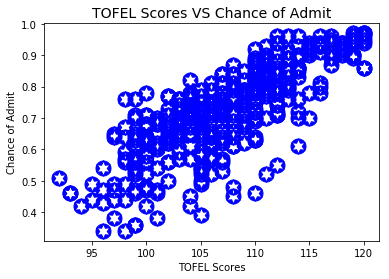

In [92]:
# plot TOEFL_Score against Chance_of_Admit
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np

star = mpath.Path.unit_regular_star(6)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)

plt.plot(pddf1.TOEFL_Score, pddf1.Chance_of_Admit, 'bo', marker=cut_star, markersize=15)
plt.title('TOFEL Scores VS Chance of Admit', fontsize=14)
plt.xlabel("TOFEL Scores")
plt.ylabel('Chance of Admit')
plt.show()

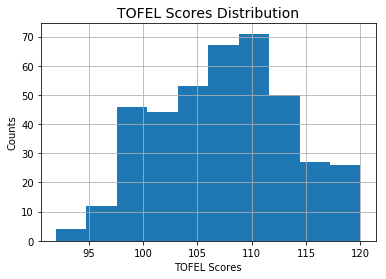

In [94]:
# plot TOFEL_Score distribution
plt.figure()
pddf1['TOEFL_Score'].hist()
plt.title('TOFEL Scores Distribution', fontsize=14)
plt.xlabel("TOFEL Scores")
plt.ylabel('Counts')
plt.show()

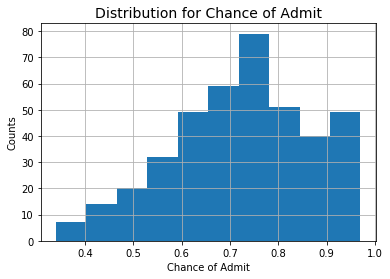

In [96]:
# plot Chance_of_Admit distribution
plt.figure()
pddf1['Chance_of_Admit'].hist()
plt.title('Distribution for Chance of Admit', fontsize=14)
plt.xlabel("Chance of Admit")
plt.ylabel('Counts')
plt.show()

In [23]:
#rm -rf data_parq

In [ ]:
#fid = open("test_data.csv", "w")
#fid.write("a,b,c\n")
#fid.write("1,2,3\n")
#fid.write("4,5,6\n")
#fid.close()